In [ ]:
%load_ext autoreload
%autoreload 2
import torch
from models.vgg19style import VGG19Style
from lib.fashionpedia_processed import FashionPediaProcessed
from tqdm.autonotebook import tqdm

In [ ]:
# load model
model = VGG19Style()

In [ ]:
# load dataset
data = FashionPediaProcessed()
data_loader = torch.utils.data.DataLoader(
    data, batch_size=16, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
import json

style_data = data[7]
content_data = data[2]

with open('fashionpedia/selected_attributes.json') as f:
    s_att = list(json.load(f).values())

print('attributes:', [s_att[i] for i, v in enumerate(content_data['att_oh']) if v])

plt.imshow(data.invImg(content_data))
plt.title('Content image')
plt.show()

print('attributes:', [s_att[i] for i, v in enumerate(style_data['att_oh']) if v])

plt.imshow(data.invImg(style_data))
plt.title('Style image')
plt.show()

In [ ]:
# target_img = target_item['img'].clone().requires_grad_(True)
noise_img = torch.normal(0, 1, content_data['img'].shape).requires_grad_(True)

plt.imshow(noise_img.detach().permute(1, 2, 0))

In [ ]:
def gram_matrix(tensor: torch.Tensor):
    depth = tensor.shape[0]
    tensor = tensor.view(depth, -1)
    return torch.mm(tensor, tensor.t()) 

In [ ]:
activations = {}
def set_activation(name):
    return lambda _, __, output: activations.update({name: output})

# content layer
model.layers[21].register_forward_hook(set_activation('conv_4_2'))

# style layers
style_layers = {0: 'conv_1_1', 5: 'conv_2_1', 10: 'conv_3_1', 19: 'conv_4_1', 28: 'conv_5_1'}
for i, name in style_layers.items():
    model.layers[i].register_forward_hook(set_activation(name))

model(content_data['img'])

content_img_feature = activations['conv_4_2']

model(style_data['img'])

style_img_grams = {i: gram_matrix(activations[name]) for i, name in style_layers.items()}

### Single image content transfer from noise

In [ ]:
import torch.nn as nn

def get_content_loss(content_img_feature, target_img_feature):
	return torch.sum((content_img_feature - target_img_feature) ** 2) / 2

In [ ]:
from tqdm import trange

optimizer = torch.optim.Adam([target_img], lr=0.003)
iterations = 3000

target_img = noise_img

for i in trange(1, iterations):
    optimizer.zero_grad()

    model(target_img)

    target_content_feature = activations['conv_4_2']

    content_loss = get_content_loss(content_img_feature, target_content_feature)

    content_loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print('loss:', content_loss.item())
        plt.imshow(target_img.detach().permute(1,2,0))
        plt.show()

### Single image style transfer from noise

In [ ]:
def get_style_loss(style_img_grams, target_img_features):
	loss = 0

	for i in style_layers.keys():
		target_gram = gram_matrix(target_img_features[i])
		squared_err = torch.sum((target_gram - style_img_grams[i]) ** 2)

		_, height, width = target_img_features[i].shape
		loss += squared_err / (4 * height ** 2 * width ** 2)

	return loss / len(style_layers)

In [ ]:
from tqdm import trange

optimizer = torch.optim.Adam([target_img], lr=0.003)
iterations = 12000

target_img = noise_img

for i in trange(1, iterations):
    optimizer.zero_grad()

    model(target_img)

    target_style_features = {i: activations[name] for i, name in style_layers.items()}

    style_loss = get_style_loss(style_img_grams, target_style_features)

    style_loss.backward()
    optimizer.step()

    if i % 500 == 0:
        print('loss:', style_loss.item())
        plt.imshow(target_img.detach().permute(1,2,0))
        plt.show()

### General style transfer on a content image

By using multiple images with the same style might generalize a style on the content image

In [ ]:
# Get all images with certain style 
floral_i = 30
checker_i = 29
stripe_i = 31

style_att_id = checker_i

style_images = []
for i, d in enumerate(data): 
	if d['att_oh'][style_att_id]:
		style_images.append(d['img'])

len_style_images = len(style_images)
print(f'Number of style images: {len_style_images}')
plt.imshow(data.invImg({'img': style_images[3]}))
plt.title(f'Style image: {s_att[style_att_id]}')
plt.show()

In [ ]:
# Set content and style image features
content_image = content_data['img']

model(content_image)

content_img_feature = activations['conv_4_2']

style_images_grams = []

for style_image in tqdm(style_images):
	model(style_image)

	style_images_grams.append({i: gram_matrix(activations[name]) for i, name in style_layers.items()})


In [ ]:
# Set constants
ALPHA = 1
BETA = 1e2
SWITCH_STYLE_IMG_EVERY = 5
ITERATIONS = 12000
LR = 3e-3

target_img = content_image

# Set optimizer
optimizer = torch.optim.Adam([target_img], lr=LR)


for i in trange(1, ITERATIONS // SWITCH_STYLE_IMG_EVERY):
    style_img_grams = style_images_grams[i % len_style_images]

    for j in range(SWITCH_STYLE_IMG_EVERY):
        optimizer.zero_grad()

        model(target_img)

        target_content_feature = activations['conv_4_2']

        content_loss = get_content_loss(content_img_feature, target_content_feature)

        target_style_features = {k: activations[name] for k, name in style_layers.items()}

        style_loss = get_style_loss(style_img_grams, target_style_features)

        total_loss = ALPHA * content_loss + BETA * style_loss

        total_loss.backward()
        optimizer.step()

    if i % 100 == 0:
        print('loss:', total_loss.item())
        plt.imshow(data.invImg({'img': target_img.detach()}))
        plt.show()

### General style transfer on a content image

By using a single style image on a content image

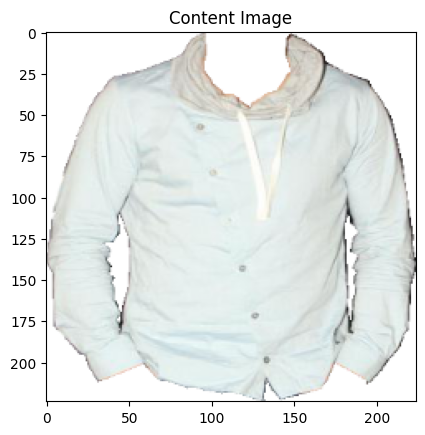

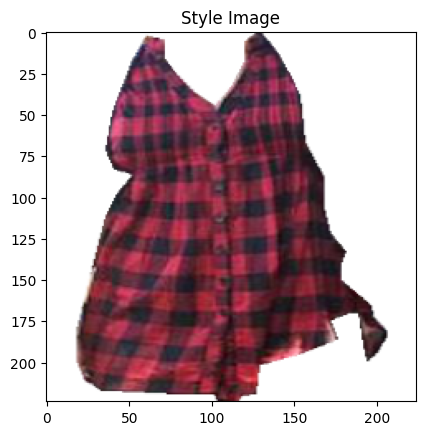

In [110]:
# Set content and style image features
content_img = content_data['img']
style_image = style_images[3]

model(content_img)

content_img_feature = activations['conv_4_2']

model(style_image)

style_img_grams = {i: gram_matrix(activations[name]) for i, name in style_layers.items()}

plt.imshow(data.invImg({'img': content_img}))
plt.title("Content Image")
plt.show()
plt.imshow(data.invImg({'img': style_image}))
plt.title("Style Image")
plt.show()

In [111]:
# Set constants
ALPHA = 1
BETA = 1e2
ITERATIONS = 12000
LR = 3e-3

# Set target image
target_img = content_img

# Set optimizer
optimizer = torch.optim.Adam([target_img], lr=LR)


for i in trange(1, ITERATIONS // SWITCH_STYLE_IMG_EVERY):
    optimizer.zero_grad()

    model(target_img)

    target_content_feature = activations['conv_4_2']

    content_loss = get_content_loss(content_img_feature, target_content_feature)

    target_style_features = {k: activations[name] for k, name in style_layers.items()}

    style_loss = get_style_loss(style_img_grams, target_style_features)

    total_loss = ALPHA * content_loss + BETA * style_loss

    total_loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print('loss:', total_loss.item())
        img = target_img.detach()
        plt.imshow(data.invImg({'img': img}))
        plt.show()

  0%|          | 1/2399 [00:03<2:07:11,  3.18s/it]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.